Project Repo on [Github](https://github.com/colischeng/ECON-323-Final-Project.git)

**Sin is in: Are Sin Stocks Worth the Risk?**

Many impact investment funds have recently popped up, touting a commitment to socially conscience investments to make the world a better place. In contrast to this investment philosophy exists assets that, while not necessarily toxic, are considered sinful. [Investopedia](https://www.investopedia.com/terms/s/sinfulstock.asp) considers sin stocks an umbrella term, but they usually encompass companies that operate in “alcohol, tobacco, gambling, sex-related industries, and weapons manufacturers”. Some economist claim that sin stocks, due to the dubious nature of their products and services, might actually have their values suppressed due to higher elasticity of investor preferences and exclusion of potential investors (i.e. pension funds), despite also being potentially recession-proof. I want to test this theory by looking at the past performance of certain American sin stocks. The sin stocks I have chose are 
- NYSE: STZ – Constellation Brands (Alcohol)
- NASDAQ: CZR – Caesars Entertainment (Gambling)
- NYSE: NOC - Northrop Grumman (Aerospace and Defense)

Whose monthly closing prices were taken from ThomsonOne

In relation to these 3 sin stocks, we will use the following macro variables
- [United States Monthly Interest Rates](https://fred.stlouisfed.org/tags/series?t=interest+rate%3Bmonthly%3Busa)
- [United States Monthly Unemployment Rates](https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm)
- NASDAQ Composite Price (taken from ThomsonOne)

A caveat regarding the use of the NASDAQ composite price is warranted. As a market index, the NASDAQ is representative of a general basket of United States stocks, and through diversification, is an adequate measure of the economy.

We first build a few **regression models** to convince ourselves that our selected macrovariables are sufficient independent variables for our study. Next, we design a filtering algorithm to determine whether or not a given sin stock outperforms an ETF. In this case, the ETF we have chosen is the [Select Sector Spdr Trust XLS ETF](http://nasdaq.com/articles/10-most-popular-etfs-of-this-year-2021-03-24), which the NASDAQ website lists as one of the most popular ETFs.

In [270]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree
)
from sklearn.ensemble import RandomForestRegressor

<br> 
First we want to clean the datasets of our macrovariables

In [271]:
# cleaning unemployment rate data set

unemployment = pd.read_excel("US-UNEMPLOYMENT.xlsx")
unemployment = unemployment.rename(columns=unemployment.iloc[10]).drop(unemployment.index[0:11]) #clean columns
unemployment = unemployment.set_index('Year') #set row indices
unemployment = unemployment.loc[2001:2020]
unemployment = unemployment.rename(columns={"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun" : 6, "Jul" : 7, "Aug" : 8, "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12})
unemployment = unemployment.rename_axis("Month", axis="columns")


In [272]:
# cleaning interest rate data set
us_int = pd.read_csv("US-INTEREST.csv")
us_int = us_int.rename(columns={"INTDSRUSM193N": "Interest Rate"})
us_int['Year'] = us_int['DATE'].str[:4].astype(int) #extract year
us_int['Month'] = us_int['DATE'].str[5:7].astype(int)
us_int = us_int[['Year','Month','Interest Rate']]
us_int = us_int.pivot(index="Year", columns="Month", values="Interest Rate")
us_int = us_int.loc[2001:2020]


In [273]:
# cleaning NASDAQ Composite data set
nas = pd.read_csv("NASDAQ-COMPOSITE.csv")
nas = nas.rename(columns=nas.iloc[0]).drop(nas.index[0]) #rewrite column index
nas = nas.iloc[::-1]
nas['Year'] = nas['Date'].str[6:].astype(int) #extract year
nas['Month'] = nas['Date'].str[:2].astype(int) #extract month
nas = nas[['Year','Close','Month']] #for pivot

nas = nas[['Year','Close','Month']]
nas = nas.pivot(index="Year", columns="Month", values="Close")
nas = nas.loc[2001:2020]

<br>
The following is our cleaned macro data sets as pivot tables.

In [274]:
# clean independent variables as pivot tables

print("US Monthly Unemployment Rates\n")
display(unemployment)
print("\n")

print("US Monthly Interest Rates\n")
display(us_int)
print("\n")

print("NASDAQ Composite Monthly Close\n")
display(nas)
print("\n")

US Monthly Unemployment Rates



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,4.2,4.2,4.3,4.4,4.3,4.5,4.6,4.9,5,5.3,5.5,5.7
2002,5.7,5.7,5.7,5.9,5.8,5.8,5.8,5.7,5.7,5.7,5.9,6
2003,5.8,5.9,5.9,6,6.1,6.3,6.2,6.1,6.1,6,5.8,5.7
2004,5.7,5.6,5.8,5.6,5.6,5.6,5.5,5.4,5.4,5.5,5.4,5.4
2005,5.3,5.4,5.2,5.2,5.1,5,5,4.9,5,5,5,4.9
2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5
2008,5,4.9,5.1,5,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
2009,7.8,8.3,8.7,9,9.4,9.5,9.5,9.6,9.8,10,9.9,9.9




US Monthly Interest Rates



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,5.52,5.00,4.81,4.28,3.73,3.47,3.25,3.16,2.77,2.02,1.58,1.33
2002,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,0.83,0.75
2003,2.25,2.25,2.25,2.25,2.25,2.00,2.00,2.00,2.00,2.00,2.00,2.00
2004,2.00,2.00,2.00,2.00,2.00,2.25,2.25,2.50,2.75,2.75,3.00,3.25
2005,3.25,3.50,3.75,3.75,4.00,4.25,4.25,4.50,4.75,4.75,5.00,5.25
2006,5.50,5.50,5.75,5.75,6.00,6.25,6.25,6.25,6.25,6.25,6.25,6.25
2007,6.25,6.25,6.25,6.25,6.25,6.25,6.25,5.75,5.25,5.00,5.00,4.75
2008,3.50,3.50,2.50,2.25,2.25,2.25,2.25,2.25,2.25,1.25,1.25,0.50
2009,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50




NASDAQ Composite Monthly Close



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,2772.72998,2151.83008,1840.26001,2116.23999,2110.48999,2161.23999,2027.13,1805.43005,1498.80005,1690.19995,1930.57996,1950.40002
2002,1934.03003,1731.48999,1845.34998,1688.22998,1615.72998,1463.20996,1328.26001,1314.84998,1172.06006,1329.75,1478.78003,1335.51001
2003,1320.91003,1337.52002,1341.17004,1464.31006,1595.91003,1622.80005,1735.02002,1810.44995,1786.93994,1932.20996,1960.26001,2003.37
2004,2066.1499,2029.81995,1994.21997,1920.15002,1986.73999,2047.79004,1887.35999,1838.09998,1896.83997,1974.98999,2096.81006,2175.43994
2005,2062.40991,2051.71997,1999.22998,1921.65002,2068.21997,2056.95996,2184.83008,2152.09009,2151.68994,2120.30005,2232.82007,2205.32007
2006,2305.82007,2281.38989,2339.79004,2322.57007,2178.87988,2172.09009,2091.46997,2183.75,2258.42993,2366.70996,2431.77002,2415.29004
2007,2463.92993,2416.1499,2421.63989,2525.09009,2604.52002,2603.22998,2546.27002,2596.36011,2701.5,2859.12012,2660.95996,2652.28003
2008,2389.86011,2271.47998,2279.1001,2412.80005,2522.65991,2292.97998,2325.55005,2367.52002,2091.87988,1720.94995,1535.56995,1577.03003
2009,1476.42004,1377.83997,1528.58997,1717.30005,1774.32996,1835.04004,1978.5,2009.06006,2122.41992,2045.10999,2144.6001,2269.1499


<br>
We also want a usable format to construct our analysis. So, the following is our cleaned macro data sets as lists.

In [275]:
# cleaning data for plots and regressions

# unemployment

unemployment_reform = unemployment.T
unemployment_reform = unemployment_reform.unstack(level=0)
unemployment_reform = unemployment_reform.to_frame()
unemployment_reform = unemployment_reform.rename(columns={0: "Unemployment"})

unemployment_reform = unemployment_reform.reset_index()
unemployment_reform['Date'] = pd.to_datetime(unemployment_reform[['Year', 'Month']].assign(DAY=1))
unemployment_reform = unemployment_reform[['Date', 'Unemployment']]
print("US Monthly Unemployment Rates\n")
display(unemployment_reform)
print("\n")

# interest rates

us_int_reform = us_int.T
us_int_reform = us_int_reform.unstack(level=0)
us_int_reform = us_int_reform.to_frame()
us_int_reform = us_int_reform.rename(columns={0: "Interest Rate"})

us_int_reform = us_int_reform.reset_index()
us_int_reform['Date'] = pd.to_datetime(us_int_reform[['Year', 'Month']].assign(DAY=1))
us_int_reform = us_int_reform[['Date', 'Interest Rate']]
print("US Monthly Interest Rates\n")
display(us_int_reform)
print("\n")

# NASDAQ

nas_reform = nas.T
nas_reform = nas_reform.unstack(level=0)
nas_reform = nas_reform.to_frame()
nas_reform = nas_reform.rename(columns={0: "NASDAQ"})
nas_reform = nas_reform['NASDAQ'].astype(float)


nas_reform = nas_reform.reset_index()
nas_reform['Date'] = pd.to_datetime(nas_reform[['Year', 'Month']].assign(DAY=1))
nas_reform = nas_reform[['Date', 'NASDAQ']]
print("NASDAQ Monthly Closing Prices\n")
display(nas_reform)
print("\n")

US Monthly Unemployment Rates



,Date,Unemployment
0,2001-01-01,4.2
1,2001-02-01,4.2
2,2001-03-01,4.3
3,2001-04-01,4.4
4,2001-05-01,4.3
...,...,...
235,2020-08-01,8.4
236,2020-09-01,7.8
237,2020-10-01,6.9
238,2020-11-01,6.7




US Monthly Interest Rates



,Date,Interest Rate
0,2001-01-01,5.52
1,2001-02-01,5.00
2,2001-03-01,4.81
3,2001-04-01,4.28
4,2001-05-01,3.73
...,...,...
235,2020-08-01,0.25
236,2020-09-01,0.25
237,2020-10-01,0.25
238,2020-11-01,0.25




NASDAQ Monthly Closing Prices



,Date,NASDAQ
0,2001-01-01,2772.72998
1,2001-02-01,2151.83008
2,2001-03-01,1840.26001
3,2001-04-01,2116.23999
4,2001-05-01,2110.48999
...,...,...
235,2020-08-01,11775.45996
236,2020-09-01,11167.50977
237,2020-10-01,10911.58984
238,2020-11-01,12198.74023


<br>
The following is our cleaned sin stock data sets.

In [276]:
# cleaning data for STZ

# for pivot table

stz = pd.read_csv("STZ-US.csv")
stz = stz.rename(columns=stz.iloc[0]).drop(stz.index[0]) #rewrite column index
stz = stz.iloc[::-1]
stz['Year'] = stz['Date'].str[6:].astype(int) #extract year
stz['Month'] = stz['Date'].str[:2].astype(int) #extract month
stz = stz[['Year','Close','SIP','Month']] #only keep closing price, SIP and month(for transformation)

stz_closing_price = stz[['Year','Close','Month']]
stz_closing_price = stz_closing_price.pivot(index="Year", columns="Month", values="Close")
stz_closing_price = stz_closing_price.loc[2001:2020]


# STZ as Lists

stz_closing_price_reform = stz_closing_price.T
stz_closing_price_reform = stz_closing_price_reform.unstack(level=0)
stz_closing_price_reform = stz_closing_price_reform.to_frame()
stz_closing_price_reform = stz_closing_price_reform.rename(columns={0: "STZ-US Closing Price"})
stz_closing_price_reform = stz_closing_price_reform['STZ-US Closing Price'].astype(float)

stz_closing_price_reform = stz_closing_price_reform.reset_index()
stz_closing_price_reform['Date'] = pd.to_datetime(stz_closing_price_reform[['Year', 'Month']].assign(DAY=1))
stz_closing_price_reform = stz_closing_price_reform[['Date', 'STZ-US Closing Price']]


**Constellation Brands (STZ)**

In [277]:
print("Constellation Brands Monthly Closing Price as a Pivot Table\n")
display(stz_closing_price)
print("\n")

print("STZ-US Monthly Closing Prices as List\n")
display(stz_closing_price_reform)
print("\n")

Constellation Brands Monthly Closing Price as a Pivot Table



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,8.43,7.98,8.97,8.16,9.66,10.25,10.53,10.59,10.41,10.26,9.48,10.71
2002,11.97,13.59,13.74,15.1,14.73,16,14.37,14.2,11.55,12.66,11.76,11.85
2003,12.53,12.31,11.35,13.4,13.78,15.7,14.43,14.38,15.24,15.69,17.25,16.47
2004,16.77,15.85,16.05,16.57,18,18.57,18.94,18.39,19.03,19.61,22.35,23.25
2005,25.96,26.76,26.43,26.35,27.81,29.5,27.4,27.52,26,23.54,23.62,26.23
2006,26.69,26.34,25.05,24.7,24.7,25,24.46,27.29,28.78,27.49,27.98,29.02
2007,24.74,23.46,21.18,22.41,24.3,24.28,21.93,24.18,24.21,25.12,23.55,23.64
2008,20.9,19.21,17.67,18.36,21.32,19.86,21.52,21.11,21.46,12.54,12.76,15.77
2009,14.52,13.05,11.9,11.59,11.56,12.68,13.66,14.79,15.15,15.82,17.11,15.93




STZ-US Monthly Closing Prices as List



,Date,STZ-US Closing Price
0,2001-01-01,8.43000
1,2001-02-01,7.98000
2,2001-03-01,8.97000
3,2001-04-01,8.16000
4,2001-05-01,9.66000
...,...,...
235,2020-08-01,184.48000
236,2020-09-01,189.50999
237,2020-10-01,165.23000
238,2020-11-01,205.84000


In [278]:
# cleaning for CZR


# for pivot table

czr = pd.read_csv("CZR-US.csv")
czr = czr.rename(columns=czr.iloc[0]).drop(czr.index[0]) #rewrite column index
czr = czr.iloc[::-1]
czr['Year'] = czr['Date'].str[6:].astype(int) #extract year
czr['Month'] = czr['Date'].str[:2].astype(int) #extract month
czr = czr[['Year','Close','SIP','Month']] #only keep closing price, SIP and month(for transformation)

czr_closing_price = czr[['Year','Close','Month']]
czr_closing_price = czr_closing_price.pivot(index="Year", columns="Month", values="Close")
czr_closing_price = czr_closing_price.loc[2001:2020]



# CZR as Lists

czr_closing_price_reform = czr_closing_price.T
czr_closing_price_reform = czr_closing_price_reform.unstack(level=0)
czr_closing_price_reform = czr_closing_price_reform.to_frame()
czr_closing_price_reform = czr_closing_price_reform.rename(columns={0: "CZR-US Closing Price"})
czr_closing_price_reform = czr_closing_price_reform['CZR-US Closing Price'].astype(float)

czr_closing_price_reform = czr_closing_price_reform.reset_index()
czr_closing_price_reform['Date'] = pd.to_datetime(czr_closing_price_reform[['Year', 'Month']].assign(DAY=1))
czr_closing_price_reform = czr_closing_price_reform[['Date', 'CZR-US Closing Price']]


**Caesars Entertainment (CZR)**

In [279]:
print("Caesars Entertainment Monthly Closing Price as a Pivot Table\n")
display(czr_closing_price)
print("\n")

print("CZR-US Monthly Closing Prices as List\n")
display(czr_closing_price_reform)
print("\n")

Caesars Entertainment Monthly Closing Price as a Pivot Table



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,6.44,5.91,5.25,7.42,9.46,13.5,10.87,10.96,9.27,10.6,13.56,16
2002,16.55,13.16,15.43,16.76,16.17,16.7,12.48,8.63,9.21,9,10.04,7.96
2003,6.93,5.71,6.63,8.06,6.89,7.72,8.65,8.09,8.67,10.93,11.2,10.3
2004,10.27,9.9,10.12,8.7,9.31,10.95,9.72,9.38,9.32,9,10.06,10.56
2005,11.92,12.01,12.4,11.01,10.26,11.64,10.57,9.24,8.01,6.7,7.46,10.41
2006,10.07,9.97,10.29,9.85,9.74,9.38,8.71,8,9.39,10.63,11.09,12.22
2007,11.86,13.09,13.08,15.99,15.76,15.4,12.74,10.01,9.53,8.71,6.92,6.79
2008,6.44,5.64,7,6.13,5.4,4.77,3.69,4.09,3.32,2.68,2.52,1.68
2009,1.5,1.06,0.9,2.06,1.68,2.5,3.68,3.36,3.06,2.17,1.51,1.3




CZR-US Monthly Closing Prices as List



,Date,CZR-US Closing Price
0,2001-01-01,6.44
1,2001-02-01,5.91
2,2001-03-01,5.25
3,2001-04-01,7.42
4,2001-05-01,9.46
...,...,...
235,2020-08-01,45.80
236,2020-09-01,56.06
237,2020-10-01,44.82
238,2020-11-01,68.12


In [280]:
# cleaning for noc

noc = pd.read_csv("NOC-US.csv")
noc = noc.rename(columns=noc.iloc[0]).drop(noc.index[0]) #rewrite column index
noc = noc.iloc[::-1]
noc['Year'] = noc['Date'].str[6:].astype(int) #extract year
noc['Month'] = noc['Date'].str[:2].astype(int) #extract month
noc = noc[['Year','Close','SIP','Month']] #only keep closing price, SIP and month(for transformation)

noc_closing_price = noc[['Year','Close','Month']]
noc_closing_price = noc_closing_price.pivot(index="Year", columns="Month", values="Close")
noc_closing_price = noc_closing_price.loc[2001:2020]

# NOC as Lists

noc_closing_price_reform = noc_closing_price.T
noc_closing_price_reform = noc_closing_price_reform.unstack(level=0)
noc_closing_price_reform = noc_closing_price_reform.to_frame()
noc_closing_price_reform = noc_closing_price_reform.rename(columns={0: "NOC-US Closing Price"})
noc_closing_price_reform = noc_closing_price_reform['NOC-US Closing Price'].astype(float)

noc_closing_price_reform = noc_closing_price_reform.reset_index()
noc_closing_price_reform['Date'] = pd.to_datetime(noc_closing_price_reform[['Year', 'Month']].assign(DAY=1))
noc_closing_price_reform = noc_closing_price_reform[['Date', 'NOC-US Closing Price']]

**Northrop Grumman (NOC)**

In [281]:
print("Northrop Grumman Monthly Closing Price as a Pivot Table\n")
display(noc_closing_price)
print("\n")

print("NOC-US Monthly Closing Prices as List\n")
display(noc_closing_price_reform)
print("\n")

Northrop Grumman Monthly Closing Price as a Pivot Table



Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2001,39.32,42.61,39.46,40.94,40.26,36.33,36.39,37.19,45.81,45.34,42.58,45.73
2002,50.63,48.55,51.28,54.73,55.02,56.7,50.21,55.7,56.26,46.78,43.96,44
2003,41.46,39.33,38.92,39.89,39.78,39.14,41.84,43.31,39.11,40.55,42.02,43.36
2004,43.87,45.86,44.64,45.02,46.78,48.72,47.72,46.86,48.38,46.95,51.1,49.31
2005,47.06,47.99,48.97,49.75,50.55,50.12,50.3,50.88,49.31,48.67,52.04,54.53
2006,56.36,58.15,61.95,60.69,58.68,58.11,60.05,60.61,61.75,60.23,60.72,61.42
2007,64.36,65.18,67.33,66.8,68.59,70.64,69.04,71.52,70.76,75.86,71.48,71.34
2008,71.99,71.31,70.59,66.74,68.46,60.69,61.13,62.46,54.92,42.54,37.15,40.86
2009,43.65,33.89,39.59,43.86,43.2,41.44,40.44,44.28,46.95,45.48,49.71,50.67




NOC-US Monthly Closing Prices as List



,Date,NOC-US Closing Price
0,2001-01-01,39.32000
1,2001-02-01,42.61000
2,2001-03-01,39.46000
3,2001-04-01,40.94000
4,2001-05-01,40.26000
...,...,...
235,2020-08-01,342.60999
236,2020-09-01,315.48999
237,2020-10-01,289.82001
238,2020-11-01,302.26001


Below is a set of time series line charts of our selected datasets. They provide a nice visualization for what to expect from our analysis

Comparison of Data Set


[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, '')]

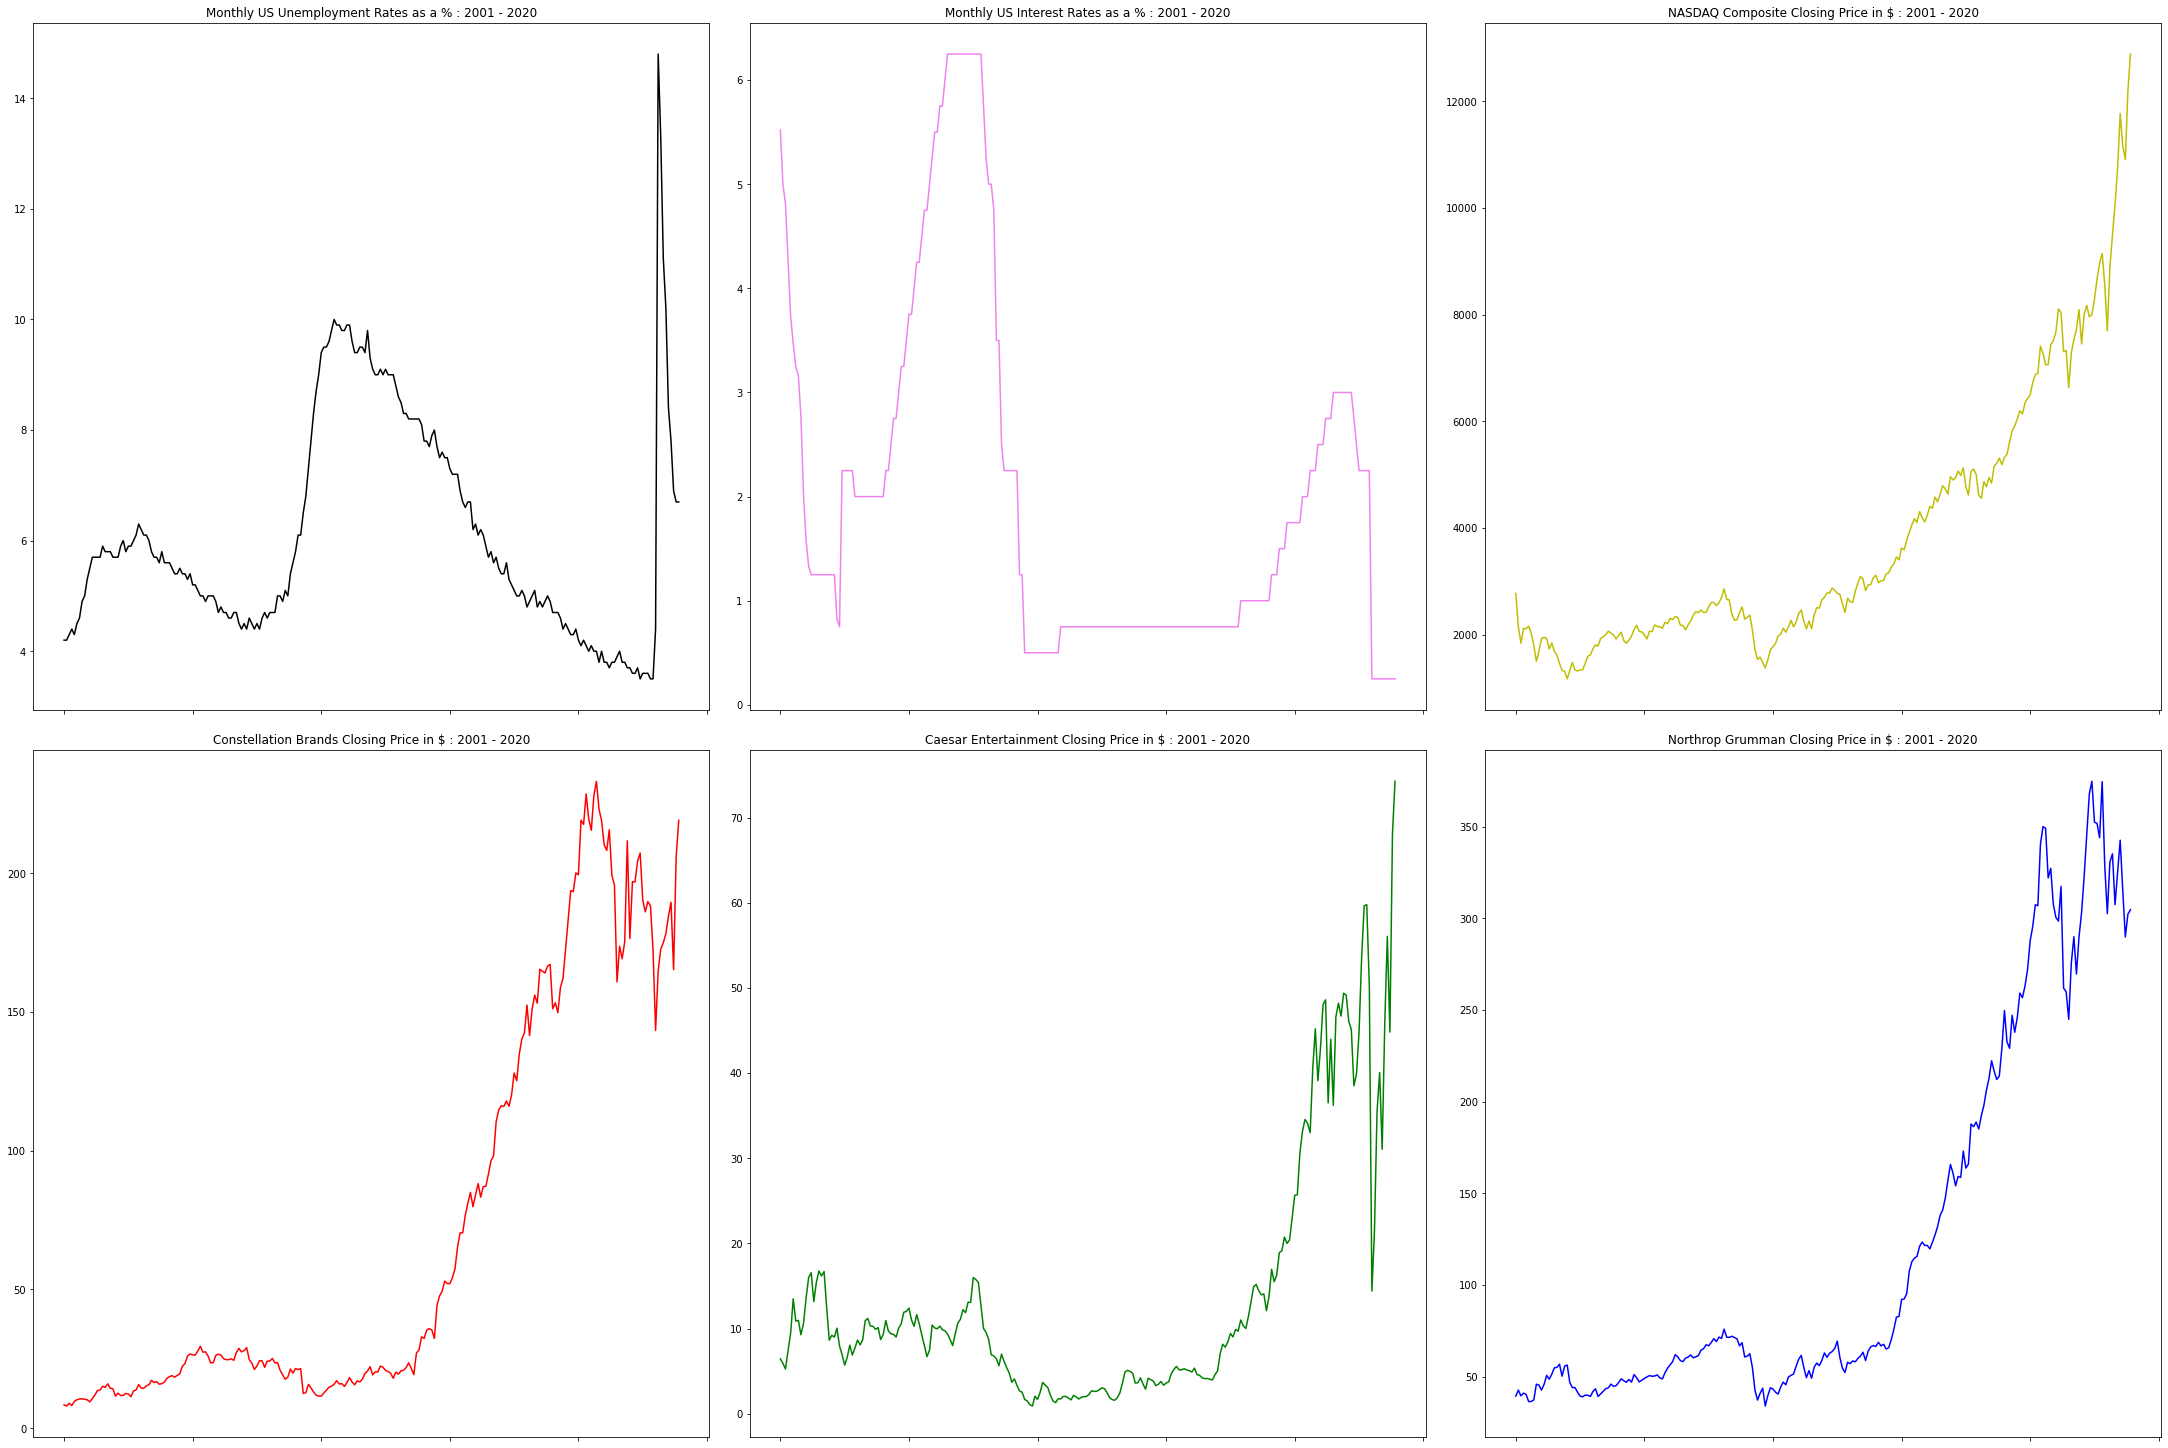

In [282]:
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(30, 20), constrained_layout=True)

print('\033[1m' + 'Comparison of Data Set')

# US Unemployment
unemployment_chart = unemployment_reform['Unemployment'].plot(title = "Monthly US Unemployment Rates as a % : 2001 - 2020", color = 'black', ax=axes[0,0])
unemployment_chart.set_xticklabels([])


# US Interest Rate
int_chart = us_int_reform['Interest Rate'].plot(title = "Monthly US Interest Rates as a % : 2001 - 2020", color = 'violet', ax=axes[0,1])
int_chart.set_xticklabels([])


# NASDAQ
nas_chart = nas_reform["NASDAQ"].plot(title = "NASDAQ Composite Closing Price in $ : 2001 - 2020", color = 'y', ax=axes[0,2])
nas_chart.set_xticklabels([])

# STZ
stz_chart = stz_closing_price_reform["STZ-US Closing Price"].plot(title = "Constellation Brands Closing Price in $ : 2001 - 2020", color = 'r', ax=axes[1,0])
stz_chart.set_xticklabels([])

# CZR
czr_chart = czr_closing_price_reform["CZR-US Closing Price"].plot(title = "Caesar Entertainment Closing Price in $ : 2001 - 2020", color = 'g', ax=axes[1,1])
czr_chart.set_xticklabels([])

# NOC
noc_chart = noc_closing_price_reform["NOC-US Closing Price"].plot(title = "Northrop Grumman Closing Price in $ : 2001 - 2020", color = 'b', ax=axes[1,2])
noc_chart.set_xticklabels([])

<br>

Let's first start off with a simple example of a univariate linear regression. We will do this by only comparing STZ-US Closing Price to the NASDAQ composite price, as the NASDAQ can act as a general
measure of economic growth. Note that we are taking the log of the NASDAQ Composite price.

In [283]:
# For analysis on STZ

stz_combined = pd.merge(stz_closing_price_reform, unemployment_reform, on='Date')
stz_combined = stz_combined.merge(us_int_reform, on='Date')
stz_combined = stz_combined.merge(nas_reform, on='Date')
stz_combined['NASDAQ'] = np.log10(stz_combined['NASDAQ']) #normalize with log base
display(stz_combined)


,Date,STZ-US Closing Price,Unemployment,Interest Rate,NASDAQ
0,2001-01-01,8.43000,4.2,5.52,3.442908
1,2001-02-01,7.98000,4.2,5.00,3.332808
2,2001-03-01,8.97000,4.3,4.81,3.264879
3,2001-04-01,8.16000,4.4,4.28,3.325565
4,2001-05-01,9.66000,4.3,3.73,3.324383
...,...,...,...,...,...
235,2020-08-01,184.48000,8.4,0.25,4.070978
236,2020-09-01,189.50999,7.8,0.25,4.047956
237,2020-10-01,165.23000,6.9,0.25,4.037888
238,2020-11-01,205.84000,6.7,0.25,4.086315


In [284]:
# Linear regression taken from Applications Lecture

linear_regression_test_stz = stz_combined[['STZ-US Closing Price','NASDAQ']]


# Let's make a scatterplot

display(linear_regression_test_stz)

,STZ-US Closing Price,NASDAQ
0,8.43000,3.442908
1,7.98000,3.332808
2,8.97000,3.264879
3,8.16000,3.325565
4,9.66000,3.324383
...,...,...
235,184.48000,4.070978
236,189.50999,4.047956
237,165.23000,4.037888
238,205.84000,4.086315


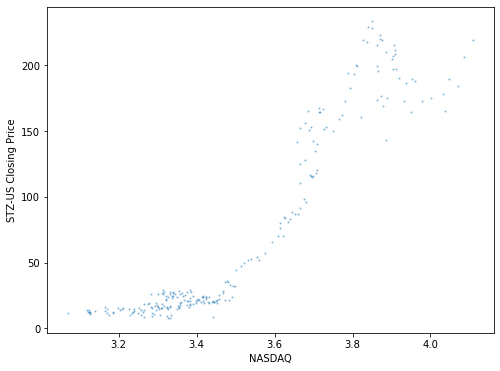

In [285]:
# code adapted from the regression lecture

def var_scatter(df, ax=None, var="NASDAQ"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    linear_regression_test_stz.plot.scatter(x=var , y="STZ-US Closing Price", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(linear_regression_test_stz);

Next, we want to fit our model:

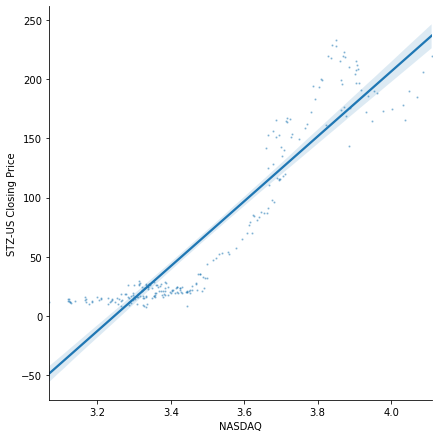

In [286]:
import seaborn as sns

sns.lmplot(
    data=linear_regression_test_stz, x="NASDAQ", y="STZ-US Closing Price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);



Assign independent and dependent variables and fit our regression.




Fit model: STZ-US Closing Price = -887.6424 + 273.5042 log10(NASDAQ)
r_sqr value: 0.8682957010601421




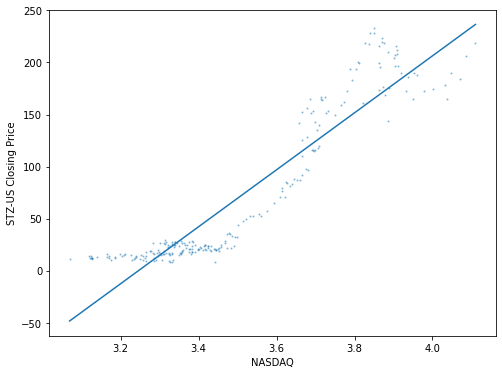

In [287]:

# import
from sklearn import linear_model

# construct the model instance
nas_lr_model = linear_model.LinearRegression()

# fit the model
nas_lr_model.fit(X_stz[["NASDAQ"]], y_stz)

# print the coefficients
beta_0 = nas_lr_model.intercept_
beta_1 = nas_lr_model.coef_[0]


X_stz = stz_combined.drop(["Date","STZ-US Closing Price"], axis=1).copy()

y_stz = stz_combined['STZ-US Closing Price']

ax = var_scatter(stz_combined)

# points for the line
x = np.array([stz_combined["NASDAQ"].min(), stz_combined["NASDAQ"].max()])
ax.plot(x, beta_0 + beta_1*x)

print("\n")
print(f"Fit model: STZ-US Closing Price = {beta_0:.4f} + {beta_1:.4f} log10(NASDAQ)")
print(f'r_sqr value: {nas_lr_model.score(X_stz[["NASDAQ"]], y_stz)}')
print("\n")

<br>

The univariate regression has a fairly high r-squared  term. Let us see if we can improve our model with a multivariate regression

We will build a multivariate regression with our dataset to try and predict the price of STZ-US using our listed macro factors

In [288]:
X_stz_multi = stz_combined.drop(["Date","STZ-US Closing Price"], axis=1).values

y_stz_multi = stz_combined['STZ-US Closing Price'].values
# We split into training and test sets

from sklearn.model_selection import train_test_split
x_train_stz, x_test_stz, y_train_stz, y_test_stz=train_test_split(X_stz_multi, y_stz_multi, test_size = 0.3, random_state=0)

In [289]:
# Train model
from sklearn.linear_model import LinearRegression

multi_stz = LinearRegression()
multi_stz.fit(x_train_stz,y_train_stz)

LinearRegression()

In [290]:
y_pred_stz=multi_stz.predict(x_test_stz)
print(y_pred_stz)

[ -2.84274843  27.91989472  30.6539985   28.19259149  -5.0130741
 208.75189169 101.51654158 181.77924146  84.98230841 161.47706869
  35.75409316 177.59054685  42.69723334 105.26740326 159.19049819
  51.39993205 142.09330349   5.72495207 190.50772649   0.33647424
 -17.45610902 140.74472161  41.17907203  30.05817598  38.83820349
   3.87464666 168.04715777 -31.69463576  30.74828355 127.95734116
  24.42197571  19.79504693  70.43113822  28.48224407  55.6719269
   8.56997536  60.1479388  135.47315401  16.77030176  25.17775962
  96.51647099  22.69478135 190.36425798  -9.56994882  -6.43975412
  14.04366203  -6.22593762  17.62977062   3.02178227 223.35341102
  24.24591633  88.98620045 140.69099548  51.86342694 -18.04952457
  20.36106985  79.99443077 102.60256079   6.91749674 125.80451976
  31.24373448 167.11959552  40.05680415 199.60815999 176.64975275
 102.04700486  10.77835732 184.26457913  28.9712481   26.6632794
  36.73573517  -0.57652745]


In [291]:
from sklearn.metrics import r2_score
print(f'r_sqr value: {r2_score(y_test_stz, y_pred_stz)}')

r_sqr value: 0.891273222386129


<br>
So, our r-squared is at least somewhat higher in the multivariate case than in the univariate case (albeit marginally).

Text(0, 0.5, 'Predicted')

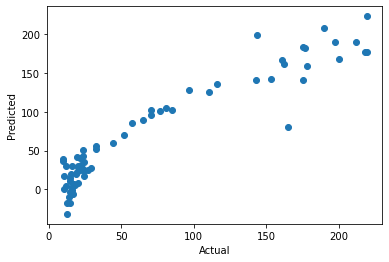

In [292]:
plt.scatter(y_test_stz, y_pred_stz)
plt.xlabel('Actual')
plt.ylabel('Predicted')

I have some fears that I may be overfitting the model. Let's compare the predicted value to the actual value

In [293]:
pred_y_stz=pd.DataFrame({'Actual Value':y_test_stz, "Predicted value": y_pred_stz, 'Difference': y_test_stz - y_pred_stz})

display(pred_y_stz)

,Actual Value,Predicted value,Difference
0,15.04,-2.842748,17.882748
1,29.02,27.919895,1.100105
2,15.85,30.653999,-14.803999
3,21.18,28.192591,-7.012591
4,16.08,-5.013074,21.093074
...,...,...,...
67,175.33,184.264579,-8.934579
68,20.22,28.971248,-8.751248
69,23.46,26.663279,-3.203279
70,9.66,36.735735,-27.075735


Absolute differences seem to be quite large, so I will instead try a Lasso regression to penalize excessive differences

In [294]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X_stz, y_stz)

lasso_coefs = pd.Series(dict(zip(list(X_stz), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X_stz), multi_stz.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs.head()

,lasso,linreg
Unemployment,-11.027940,-12.935843
Interest Rate,-7.779959,-8.544897
NASDAQ,227.212229,239.150756


There does not seem to be any meaningful penalization in the lasso regression. This is likely due to the fact that we do not have many independent variables in our model. 

This is generally still okay. More than anything, I was hoping to confirm that Unemployment, Interest Rate, and the log of the NASDAQ Composite would be generally good
choices of independent variables to use, which seems to be the case from their high r-squared values.

We then run a random forest regressor on our training and test sets.

In [295]:
from sklearn.ensemble import RandomForestClassifier
ran_model_stz = RandomForestRegressor()
ran_model_stz.fit(x_train_stz, y_train_stz)

RandomForestRegressor()

In [296]:
ran_model_stz.score(x_test_stz, y_test_stz)

0.984496078920908

Our random forest regressor on STZ returns a high score!

<br>

We want to conduct similar (abridged) analysis to Caesar Entertainment

In [297]:
# For analysis on CZR

czr_combined = pd.merge(czr_closing_price_reform, unemployment_reform, on='Date')
czr_combined = czr_combined.merge(us_int_reform, on='Date')
czr_combined = czr_combined.merge(nas_reform, on='Date')
czr_combined['NASDAQ'] = np.log10(czr_combined['NASDAQ']) #normalize with log base
display(czr_combined)

,Date,CZR-US Closing Price,Unemployment,Interest Rate,NASDAQ
0,2001-01-01,6.44,4.2,5.52,3.442908
1,2001-02-01,5.91,4.2,5.00,3.332808
2,2001-03-01,5.25,4.3,4.81,3.264879
3,2001-04-01,7.42,4.4,4.28,3.325565
4,2001-05-01,9.46,4.3,3.73,3.324383
...,...,...,...,...,...
235,2020-08-01,45.80,8.4,0.25,4.070978
236,2020-09-01,56.06,7.8,0.25,4.047956
237,2020-10-01,44.82,6.9,0.25,4.037888
238,2020-11-01,68.12,6.7,0.25,4.086315


In [298]:
X_czr_multi = czr_combined.drop(["Date","CZR-US Closing Price"], axis=1).values

y_czr_multi = czr_combined['CZR-US Closing Price'].values
# We split into training and test sets

from sklearn.model_selection import train_test_split
x_train_czr, x_test_czr, y_train_czr, y_test_czr=train_test_split(X_czr_multi, y_czr_multi, test_size = 0.3, random_state=0)

# Train model
from sklearn.linear_model import LinearRegression

multi_czr = LinearRegression()
multi_czr.fit(x_train_czr,y_train_czr)

y_pred_czr=multi_czr.predict(x_test_czr)
print(y_pred_czr)

print(f'r_sqr value: {r2_score(y_test_czr, y_pred_czr)}')

[ 0.61132967 15.16647478  5.77529415 15.2141991  -0.41514071 35.71850026
 15.8797074  33.03158915 13.54771162 26.25391164 16.53752833 29.53334278
 14.43441326 16.62974786 28.04970974  8.60656787 21.94272065  2.20435926
 34.465544    1.89948522 -2.8736013  21.89392041  8.26391881  5.62042678
  9.98019663 -1.65680297 28.05037928 -6.4887492   3.94546862 19.7582259
 10.49583157  5.62760174 11.28194914  5.43823157  9.16699107  2.60865661
  9.66951232 20.69913231 12.75576716  5.93158214 15.28547126  6.22868746
 34.53404247 -3.01696957 -0.57121553  1.20922652 -0.62740248  5.84112245
  1.73128079 36.00254813 13.51102779 14.24842791 25.65459469  8.59407683
 -4.56876844  4.34836807 18.49561111 16.16337702  2.03863818 19.28785652
 15.84178265 30.65323574  8.25472551 29.69396606 29.27508883 16.06614985
  0.54416279 33.5601518   5.24299142 15.04016277 10.09754286  0.45490065]
r_sqr value: 0.5910634395786691


<br>

That is a rather disappointing r-squared value, although not necessarily horrible. This likely means there are other underlying macrovariable (or perhaps even company-level micro variables) that have an
impact on CZR's price performance. I am still curious about its performance in our random forest model.



In [299]:
ran_model_czr = RandomForestRegressor()
ran_model_czr.fit(x_train_czr, y_train_czr)

RandomForestRegressor()

In [300]:
ran_model_czr.score(x_test_czr, y_test_czr)

0.8943259223779354

<br>

Lastly, we conduct the same analysis for Northrop Grumman.

In [301]:
noc_combined = pd.merge(noc_closing_price_reform, unemployment_reform, on='Date')
noc_combined = noc_combined.merge(us_int_reform, on='Date')
noc_combined = noc_combined.merge(nas_reform, on='Date')
noc_combined['NASDAQ'] = np.log10(noc_combined['NASDAQ']) #normalize with log base
display(noc_combined)

,Date,NOC-US Closing Price,Unemployment,Interest Rate,NASDAQ
0,2001-01-01,39.32000,4.2,5.52,3.442908
1,2001-02-01,42.61000,4.2,5.00,3.332808
2,2001-03-01,39.46000,4.3,4.81,3.264879
3,2001-04-01,40.94000,4.4,4.28,3.325565
4,2001-05-01,40.26000,4.3,3.73,3.324383
...,...,...,...,...,...
235,2020-08-01,342.60999,8.4,0.25,4.070978
236,2020-09-01,315.48999,7.8,0.25,4.047956
237,2020-10-01,289.82001,6.9,0.25,4.037888
238,2020-11-01,302.26001,6.7,0.25,4.086315


In [302]:
X_noc_multi = noc_combined.drop(["Date","NOC-US Closing Price"], axis=1).values

y_noc_multi = noc_combined['NOC-US Closing Price'].values
# We split into training and test sets

from sklearn.model_selection import train_test_split
x_train_noc, x_test_noc, y_train_noc, y_test_noc=train_test_split(X_noc_multi, y_noc_multi, test_size = 0.3, random_state=0)

# Train model

multi_noc = LinearRegression()
multi_noc.fit(x_train_czr,y_train_noc)

y_pred_noc=multi_noc.predict(x_test_noc)

print(f'r_sqr value: {r2_score(y_test_noc, y_pred_noc)}')

r_sqr value: 0.8714225307997892


This is a fairly high r-squared value.

In [303]:
ran_model_noc = RandomForestRegressor()
ran_model_noc.fit(x_train_noc, y_train_noc)

RandomForestRegressor()

In [304]:
ran_model_noc.score(x_test_noc, y_test_noc)

0.9909730484841375

More than anything, the above regression analyses were used as a basis to gain confidence in our macrovariables' predictive powers. To answer the question "Do sin stocks perform better during recessions", we will come up with a simple algorithm that follows:

If two out of three of our macrovariables declined between periods (interest rates decreased, unemployment increased, the NASDAQ decreased), then we have a "Down Period", and we look at the relative performance between the sin stock and the ETF. If the sin stock had a larger relative performance gain as a % (or had a smaller relative performance loss as a %), then we consider the sin stock to have outperformed the ETF. 

First we need to figure out which time periods interest rates decreased, unemployment increased, and the NASDAQ decreased.

In [305]:
period_table = unemployment_reform
period_table = period_table.merge(us_int_reform, on='Date')
period_table = period_table.merge(nas_reform, on='Date')

period_table["Unemployment Increased?"] = period_table["Unemployment"].diff()
period_table["Unemployment Increased?"] = period_table["Unemployment Increased?"] >= 0

period_table["Interest Rate Decreased?"] = period_table["Interest Rate"].diff()
period_table["Interest Rate Decreased?"] = period_table["Interest Rate Decreased?"] <= 0

period_table["NASDAQ Decreased?"] = period_table["NASDAQ"].diff()
period_table["NASDAQ Decreased?"] = period_table["NASDAQ Decreased?"] <= 0

period_table.head()

,Date,Unemployment,Interest Rate,NASDAQ,Unemployment Increased?,Interest Rate Decreased?,NASDAQ Decreased?
0,2001-01-01,4.2,5.52,2772.72998,False,False,False
1,2001-02-01,4.2,5.00,2151.83008,True,True,True
2,2001-03-01,4.3,4.81,1840.26001,True,True,True
3,2001-04-01,4.4,4.28,2116.23999,True,True,False
4,2001-05-01,4.3,3.73,2110.48999,False,True,True


And then figure out which periods had two of these three events happen

In [306]:
period_table["Down_Period"] = (period_table["Unemployment Increased?"] & period_table["Interest Rate Decreased?"]) | (period_table["Unemployment Increased?"] & period_table["NASDAQ Decreased?"]) | (period_table["Interest Rate Decreased?"] & period_table["NASDAQ Decreased?"]) 

display(period_table.head())

period_table.Down_Period.value_counts()

,Date,Unemployment,Interest Rate,NASDAQ,Unemployment Increased?,Interest Rate Decreased?,NASDAQ Decreased?,Down_Period
0,2001-01-01,4.2,5.52,2772.72998,False,False,False,False
1,2001-02-01,4.2,5.00,2151.83008,True,True,True,True
2,2001-03-01,4.3,4.81,1840.26001,True,True,True,True
3,2001-04-01,4.4,4.28,2116.23999,True,True,False,True
4,2001-05-01,4.3,3.73,2110.48999,False,True,True,True


True     162
False     78
Name: Down_Period, dtype: int64

**We have 162 periods of interest, where we have labeled as a Down_Period**

In [307]:
period_table = period_table.drop(columns=['Unemployment Increased?', 'Interest Rate Decreased?', 'NASDAQ Decreased?'])

We first clean our data of the ETF's performance

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, '')]

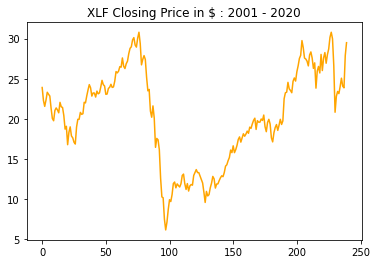

In [308]:
# cleaning XLF ETF data set
xlf = pd.read_csv("XLF-US.csv")
xlf = xlf.rename(columns=xlf.iloc[0]).drop(xlf.index[0]) #rewrite column index
xlf = xlf.iloc[::-1]
xlf['Year'] = xlf['Date'].str[6:].astype(int) #extract year
xlf['Month'] = xlf['Date'].str[:2].astype(int) #extract month
xlf = xlf[['Year','Close','Month']] #for pivot

xlf = xlf[['Year','Close','Month']]
xlf = xlf.pivot(index="Year", columns="Month", values="Close")
xlf = xlf.loc[2001:2020]

xlf_closing_price_reform = xlf.T
xlf_closing_price_reform = xlf_closing_price_reform.unstack(level=0)
xlf_closing_price_reform = xlf_closing_price_reform.to_frame()
xlf_closing_price_reform = xlf_closing_price_reform.rename(columns={0: "XLF-US Closing Price"})
xlf_closing_price_reform = xlf_closing_price_reform['XLF-US Closing Price'].astype(float)

xlf_closing_price_reform = xlf_closing_price_reform.reset_index()
xlf_closing_price_reform['Date'] = pd.to_datetime(xlf_closing_price_reform[['Year', 'Month']].assign(DAY=1))
xlf_closing_price_reform = xlf_closing_price_reform[['Date', 'XLF-US Closing Price']]

xlf_closing_price_reform
xlf_closing_price_reform["XLF-Relative Change %"] = xlf_closing_price_reform['XLF-US Closing Price'].pct_change()

xlf_chart = xlf_closing_price_reform["XLF-US Closing Price"].plot(title = "XLF Closing Price in $ : 2001 - 2020", color = 'orange')
stz_chart.set_xticklabels([])

Next we combine

In [309]:
stz_combined = stz_combined.merge(xlf_closing_price_reform, on='Date')
stz_combined = stz_combined[['Date','XLF-US Closing Price', "XLF-Relative Change %", 'STZ-US Closing Price']]
stz_combined["STZ-Relative Change %"] = stz_combined["STZ-US Closing Price"].pct_change()

stz_combined = stz_combined.merge(period_table, on='Date')

In [310]:
stz_combined.head()

,Date,XLF-US Closing Price,XLF-Relative Change %,STZ-US Closing Price,STZ-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period
0,2001-01-01,23.90,NaN,8.43,NaN,4.2,5.52,2772.72998,False
1,2001-02-01,22.29,-0.067364,7.98,-0.053381,4.2,5.00,2151.83008,True
2,2001-03-01,21.55,-0.033199,8.97,0.124060,4.3,4.81,1840.26001,True
3,2001-04-01,22.33,0.036195,8.16,-0.090301,4.4,4.28,2116.23999,True
4,2001-05-01,23.31,0.043887,9.66,0.183824,4.3,3.73,2110.48999,True


In [311]:
# Only keep down periods
stz_combined = stz_combined[stz_combined['Down_Period'] == True]

In [312]:
# Now we add a new column that tests whether if our sin stock performed better, or if the ETF performed better during the down period

stz_combined['Sin_Outperformed'] = stz_combined['STZ-Relative Change %'] > stz_combined['XLF-Relative Change %']
display(stz_combined.head())
stz_combined.Sin_Outperformed.value_counts()

,Date,XLF-US Closing Price,XLF-Relative Change %,STZ-US Closing Price,STZ-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period,Sin_Outperformed
1,2001-02-01,22.29,-0.067364,7.98,-0.053381,4.2,5.00,2151.83008,True,True
2,2001-03-01,21.55,-0.033199,8.97,0.124060,4.3,4.81,1840.26001,True,True
3,2001-04-01,22.33,0.036195,8.16,-0.090301,4.4,4.28,2116.23999,True,False
4,2001-05-01,23.31,0.043887,9.66,0.183824,4.3,3.73,2110.48999,True,True
5,2001-06-01,23.06,-0.010725,10.25,0.061077,4.5,3.47,2161.23999,True,True


True     98
False    64
Name: Sin_Outperformed, dtype: int64

In [313]:
def sin_outperformed(boolean) :
    if (boolean) : 
        return "Sin Outperformed ETF"
    else :
        return "Sin Did not Outperformed ETF"

<AxesSubplot:>

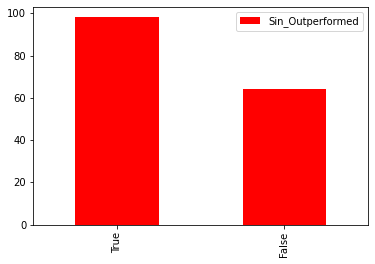

In [314]:
stz_hist = stz_combined['Sin_Outperformed'].to_frame().apply(pd.value_counts).plot.bar(color='r')
stz_hist

**For Constellation Brands, it outperformed our benchmark XLS ETF 98 out of 162 Down Periods**

Now we move onto Caesar Entertainment

In [315]:
czr_combined = czr_combined.merge(xlf_closing_price_reform, on='Date')
czr_combined = czr_combined[['Date','XLF-US Closing Price', "XLF-Relative Change %", 'CZR-US Closing Price']]
czr_combined["CZR-Relative Change %"] = czr_combined["CZR-US Closing Price"].pct_change()

czr_combined = czr_combined.merge(period_table, on='Date')

In [316]:
czr_combined.head()

,Date,XLF-US Closing Price,XLF-Relative Change %,CZR-US Closing Price,CZR-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period
0,2001-01-01,23.90,NaN,6.44,NaN,4.2,5.52,2772.72998,False
1,2001-02-01,22.29,-0.067364,5.91,-0.082298,4.2,5.00,2151.83008,True
2,2001-03-01,21.55,-0.033199,5.25,-0.111675,4.3,4.81,1840.26001,True
3,2001-04-01,22.33,0.036195,7.42,0.413333,4.4,4.28,2116.23999,True
4,2001-05-01,23.31,0.043887,9.46,0.274933,4.3,3.73,2110.48999,True


In [317]:
# Only keep down periods
czr_combined = czr_combined[czr_combined['Down_Period'] == True]

In [318]:
# Now we add a new column that tests whether if our sin stock performed better, or if the ETF performed better during the down period

czr_combined['Sin_Outperformed'] = czr_combined['CZR-Relative Change %'] > czr_combined['XLF-Relative Change %']
display(czr_combined.head())
czr_combined.Sin_Outperformed.value_counts()

,Date,XLF-US Closing Price,XLF-Relative Change %,CZR-US Closing Price,CZR-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period,Sin_Outperformed
1,2001-02-01,22.29,-0.067364,5.91,-0.082298,4.2,5.00,2151.83008,True,False
2,2001-03-01,21.55,-0.033199,5.25,-0.111675,4.3,4.81,1840.26001,True,False
3,2001-04-01,22.33,0.036195,7.42,0.413333,4.4,4.28,2116.23999,True,True
4,2001-05-01,23.31,0.043887,9.46,0.274933,4.3,3.73,2110.48999,True,True
5,2001-06-01,23.06,-0.010725,13.50,0.427061,4.5,3.47,2161.23999,True,True


True     86
False    76
Name: Sin_Outperformed, dtype: int64

<AxesSubplot:>

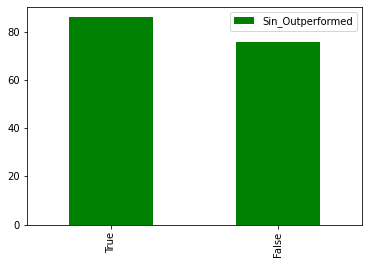

In [319]:
czr_hist = czr_combined['Sin_Outperformed'].to_frame().apply(pd.value_counts).plot.bar(color='g')
czr_hist

**For Caesar Entertainment, it outperformed our benchmark XLS ETF 86 out of 162 Down Periods**

Now we move onto Northrop Grumman

In [320]:
noc_combined = noc_combined.merge(xlf_closing_price_reform, on='Date')
noc_combined = noc_combined[['Date','XLF-US Closing Price', "XLF-Relative Change %", 'NOC-US Closing Price']]
noc_combined["NOC-Relative Change %"] = noc_combined["NOC-US Closing Price"].pct_change()

noc_combined = noc_combined.merge(period_table, on='Date')

In [321]:
noc_combined.head()

,Date,XLF-US Closing Price,XLF-Relative Change %,NOC-US Closing Price,NOC-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period
0,2001-01-01,23.90,NaN,39.32,NaN,4.2,5.52,2772.72998,False
1,2001-02-01,22.29,-0.067364,42.61,0.083672,4.2,5.00,2151.83008,True
2,2001-03-01,21.55,-0.033199,39.46,-0.073926,4.3,4.81,1840.26001,True
3,2001-04-01,22.33,0.036195,40.94,0.037506,4.4,4.28,2116.23999,True
4,2001-05-01,23.31,0.043887,40.26,-0.016610,4.3,3.73,2110.48999,True


In [322]:
# Only keep down periods
noc_combined = noc_combined[noc_combined['Down_Period'] == True]

In [323]:
# Now we add a new column that tests whether if our sin stock performed better, or if the ETF performed better during the down period

noc_combined['Sin_Outperformed'] = noc_combined['NOC-Relative Change %'] > noc_combined['XLF-Relative Change %']
display(noc_combined.head())
noc_combined.Sin_Outperformed.value_counts()

,Date,XLF-US Closing Price,XLF-Relative Change %,NOC-US Closing Price,NOC-Relative Change %,Unemployment,Interest Rate,NASDAQ,Down_Period,Sin_Outperformed
1,2001-02-01,22.29,-0.067364,42.61,0.083672,4.2,5.00,2151.83008,True,True
2,2001-03-01,21.55,-0.033199,39.46,-0.073926,4.3,4.81,1840.26001,True,False
3,2001-04-01,22.33,0.036195,40.94,0.037506,4.4,4.28,2116.23999,True,True
4,2001-05-01,23.31,0.043887,40.26,-0.016610,4.3,3.73,2110.48999,True,False
5,2001-06-01,23.06,-0.010725,36.33,-0.097615,4.5,3.47,2161.23999,True,False


True     96
False    66
Name: Sin_Outperformed, dtype: int64

<AxesSubplot:>

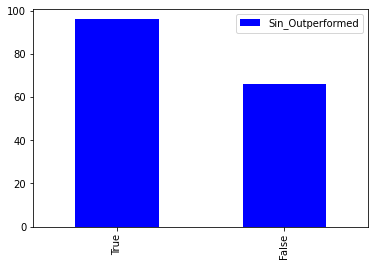

In [324]:
noc_hist = noc_combined['Sin_Outperformed'].to_frame().apply(pd.value_counts).plot.bar(color='b')
noc_hist

**For Northrop Grumman, it outperformed our benchmark XLS ETF 96 out of 162 Down Periods**

It seems all 3 of our sin stocks outperformed the benchmark ETF in the majority of downside cases. While we would ideally like to conclude that sin stocks do in fact perform better during recessions than benchmark investments, this claim is simply too substantial. Here are a few of the limitations of our case study

- Overfitting the model is something that could have happened, and unfortunately is something we could have not have efficiently fixed given our limited number of independent variables.
- The scope of our data is too small. We very easily could have cherrypicked our information to select several sin stocks that would over perform during recessions, and an ETF that would underperform during recessions. 
- The companies in our dataset are fundamentally different. We attribute our superior returns to the "sin" and dubious nature of the stocks, but this simply does not paint the full picture from which we can generalize. The fundamentals, risk, and cash flow profiles of an alcohol company and a weapons manufacturer are going to be very different.
- The risk profiles of the companies in our dataset are vastly different. Sin stocks tended to generate a higher return than an ETF, which is something that is to be expected. Retail investors invest in ETF because they want to generate a moderate return at a somewhat lower risk than holding a single stock or asset. In contrast, individual stocks are supposed to generate higher returns, but also have higher risk metrics than ETFs. A more precise model would incorporate some form of risk metric such as the weight-average cost of capital (WACC).

A good future study would be to use a more expansive data set, more macrovariables, and a wider scope in time and varieties of sin stocks and benchmarks.